In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

In [3]:
#Downloading of data from Yahoo Finance which will be used for model training
end = '2019-12-31'
start = '1999-01-02'

trainingData = yf.download('^GSPC', start=start, end=end)
trainingData.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-04,1229.229980,1248.810059,1219.099976,1228.099976,1228.099976,877000000
1999-01-05,1228.099976,1246.109985,1228.099976,1244.780029,1244.780029,775000000
1999-01-06,1244.780029,1272.500000,1244.780029,1272.339966,1272.339966,986900000
1999-01-07,1272.339966,1272.339966,1257.680054,1269.729980,1269.729980,863000000
1999-01-08,1269.729980,1278.239990,1261.819946,1275.089966,1275.089966,937800000


In [4]:
#Downloading of data from Yahoo Finance which will be used for model testing
end = '2024-04-09'
start = '2020-01-02'

testingData = yf.download('^GSPC', start=start, end=end)
testingData.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,3244.669922,3258.139893,3235.530029,3257.850098,3257.850098,3459930000
2020-01-03,3226.360107,3246.149902,3222.340088,3234.850098,3234.850098,3484700000
2020-01-06,3217.550049,3246.840088,3214.639893,3246.280029,3246.280029,3702460000
2020-01-07,3241.860107,3244.909912,3232.429932,3237.179932,3237.179932,3435910000
2020-01-08,3238.590088,3267.070068,3236.669922,3253.050049,3253.050049,3726840000


In [5]:
#Prediction will take place on Adj Close price, therefore we must isolate Adj Close.
trainprice = trainingData['Adj Close']
trainData = trainprice.values

testprice = testingData['Adj Close']
testData = testprice.values

In [6]:
trainData

array([1228.09997559, 1244.7800293 , 1272.33996582, ..., 3239.90991211,
       3240.02001953, 3221.29003906])

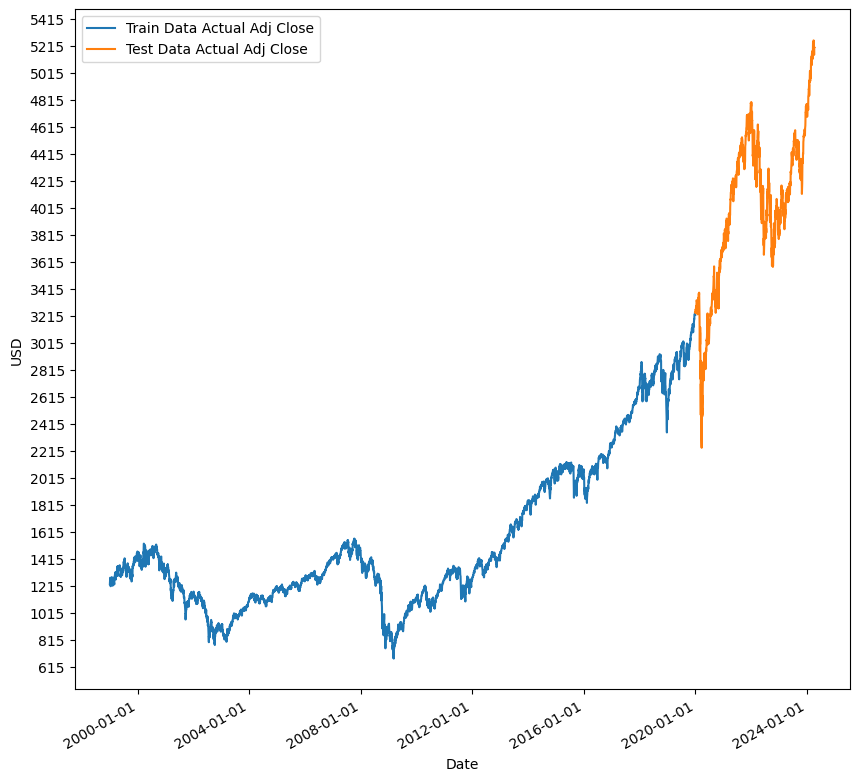

In [7]:
plt.figure(figsize=(10,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().yaxis.set_major_locator(mdates.DayLocator(interval=200))

plt.plot(trainingData.index, trainingData['Adj Close'], label='Train Data Actual Adj Close')
plt.plot(testingData.index, testingData['Adj Close'], label='Test Data Actual Adj Close')
plt.xlabel('Date')
plt.ylabel('USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

In [8]:
sc = MinMaxScaler(feature_range=(0,1))
trainDataScaled = sc.fit_transform(trainData.reshape(-1, 1))
testDataScaled = sc.fit_transform(testData.reshape(-1, 1))

In [9]:
n_steps = 20

xTrain, yTrain = [], []

for i in range(n_steps, len(trainDataScaled)):
    xTrain.append(trainDataScaled[i-n_steps:i, 0])
    yTrain.append(trainDataScaled[i, 0])

xTrain, yTrain = np.array(xTrain), np.array(yTrain)
xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], 1))

In [10]:
#LSTM Model

model = Sequential()

#Layer 1
model.add(LSTM(units=200,return_sequences=True,input_shape=(xTrain.shape[1], 1)))
model.add(Dropout(0.2))
#Layer 2
model.add(LSTM(units=200,return_sequences=True))
model.add(Dropout(0.2))
#Layer 3
model.add(LSTM(units=200,return_sequences=True))
model.add(Dropout(0.2))
#Layer 4
model.add(LSTM(units=200, return_sequences=False))
model.add(Dropout(0.2))
#Layer 5
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error', metrics=[RootMeanSquaredError(), MeanAbsoluteError()])
model.summary()

#Early stopping parameters to stop unnecessary training
earlyStopping = EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=15,
    mode='min',
    min_delta = 0.000001
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 200)           161600    
                                                                 
 dropout (Dropout)           (None, 20, 200)           0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 200)           320800    
                                                                 
 dropout_1 (Dropout)         (None, 20, 200)           0         
                                                                 
 lstm_2 (LSTM)               (None, 20, 200)           320800    
                                                                 
 dropout_2 (Dropout)         (None, 20, 200)           0         
                                                                 
 lstm_3 (LSTM)               (None, 200)               3

In [11]:
#Method to plot the training metric vs validation metric
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [12]:
#Evaluation of model to confirm if parameters set above are valid
eval = model.evaluate(xTrain, yTrain)

165/165 [==============================] - 13s 65ms/step - loss: 0.1703 - root_mean_squared_error: 0.4127 - mean_absolute_error: 0.3465


In [13]:
len(xTrain)

5262

Epoch 1/100
31/31 [==============================] - 28s 579ms/step - loss: 0.0069 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0628 - val_loss: 0.0259 - val_root_mean_squared_error: 0.1610 - val_mean_absolute_error: 0.1369
Epoch 2/100
31/31 [==============================] - 18s 569ms/step - loss: 0.0101 - root_mean_squared_error: 0.1006 - mean_absolute_error: 0.0823 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1078 - val_mean_absolute_error: 0.0837
Epoch 3/100
31/31 [==============================] - 18s 573ms/step - loss: 0.0115 - root_mean_squared_error: 0.1072 - mean_absolute_error: 0.0906 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1205 - val_mean_absolute_error: 0.0964
Epoch 4/100
31/31 [==============================] - 18s 567ms/step - loss: 0.0104 - root_mean_squared_error: 0.1019 - mean_absolute_error: 0.0848 - val_loss: 0.0687 - val_root_mean_squared_error: 0.2621 - val_mean_absolute_error: 0.2419
Epoch 5/100
31/31 [=============================

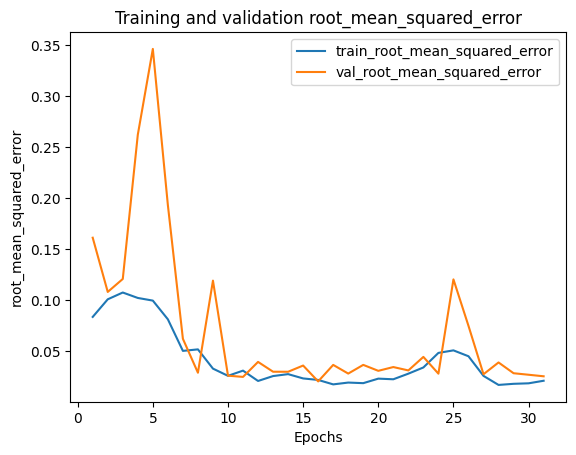

In [14]:
log = model.fit(
    xTrain,
    yTrain,
    epochs=100,
    batch_size=128,
    validation_split = 0.25,
    verbose=1,
    callbacks=[earlyStopping],
    shuffle=False)
plot_metric(log, 'root_mean_squared_error')

In [15]:
n_steps = 20

xTest = []
yTest = []

for i in range(n_steps, len(testDataScaled)):
    xTest.append(testDataScaled[i-n_steps:i, 0])
    yTest.append(testDataScaled[i, 0])

xTest, yTest = np.array(xTest), np.array(yTest)
xTest = np.reshape(xTest, (xTest.shape[0], xTest.shape[1], 1))

In [16]:
predictions = model.predict(xTest) #Prediction on Data using trained model
output = sc.inverse_transform(predictions)
rmse = np.sqrt(mean_squared_error(predictions, yTest)) #Calculating of RMSE
rmse

33/33 [==============================] - 5s 77ms/step


0.03731045469630403

In [17]:
eval = model.evaluate(xTest, yTest) #Calculating of additional metrics (Loss, RMSE, MAE)

33/33 [==============================] - 2s 66ms/step - loss: 0.0014 - root_mean_squared_error: 0.0373 - mean_absolute_error: 0.0275


In [18]:
df1 = pd.DataFrame(testingData['Adj Close']).astype(float)
df1 = df1.iloc[:-20]
df1 = df1.reset_index(drop=False)

df2 = pd.DataFrame(output, columns = ['Pred Adj Close']).astype(float)

In [19]:
df2

,Pred Adj Close
0,3348.487061
1,3343.311523
2,3337.049561
3,3331.848389
4,3329.987549
...,...
1048,5063.169922
1049,5067.627930
1050,5070.608887
1051,5070.994629


In [20]:
df = df1.join(df2)
df = df.set_index('Date')

In [21]:
df

,Adj Close,Pred Adj Close
Date,,
2020-01-02,3257.850098,3348.487061
2020-01-03,3234.850098,3343.311523
2020-01-06,3246.280029,3337.049561
2020-01-07,3237.179932,3331.848389
2020-01-08,3253.050049,3329.987549
...,...,...
2024-03-04,5130.950195,5063.169922
2024-03-05,5078.649902,5067.627930
2024-03-06,5104.759766,5070.608887


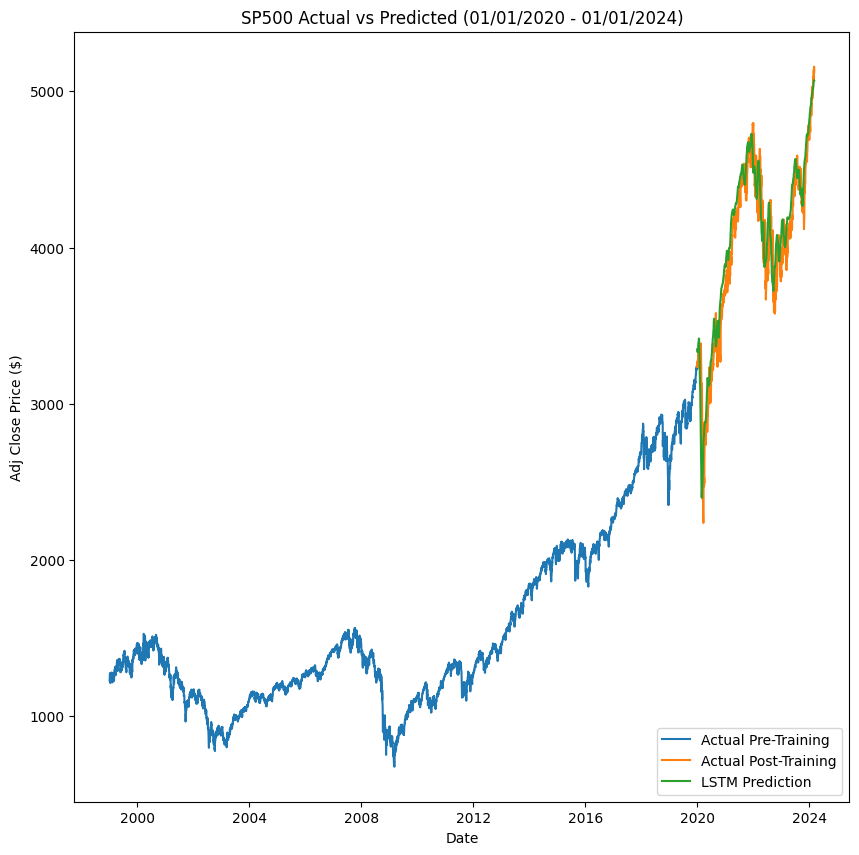

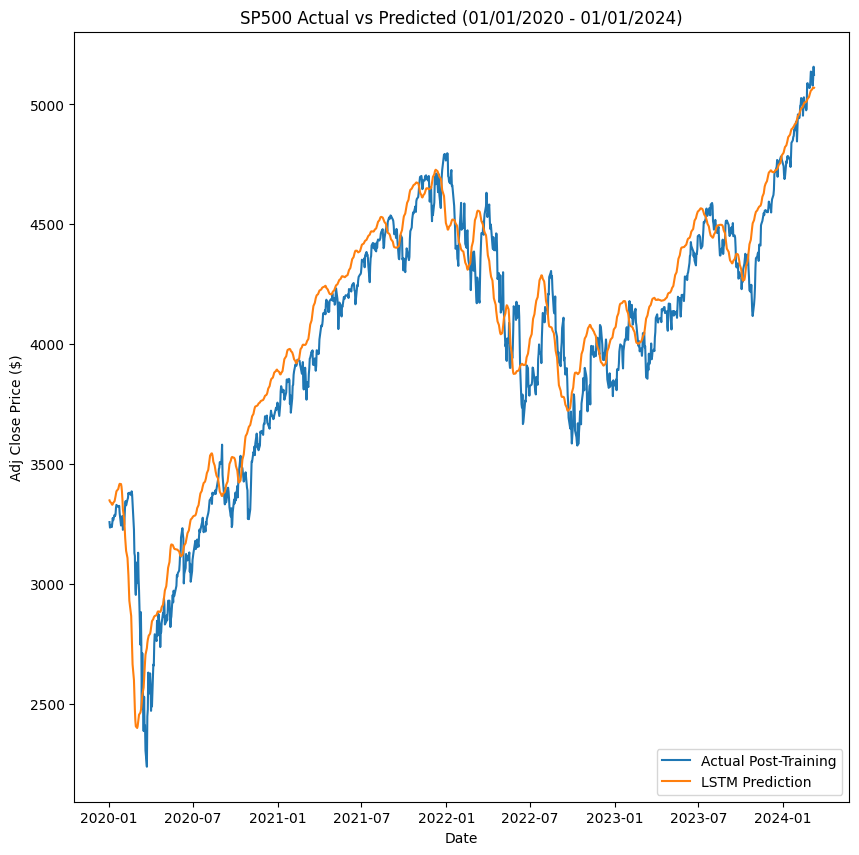

In [24]:
#plotting of graphs - Full Overview

train = trainingData['Adj Close']
real = df['Adj Close']
pred = df['Pred Adj Close']
plt.figure(figsize=(10,10))
plt.title('SP500 Actual vs Predicted (01/01/2020 - 01/01/2024)')
plt.xlabel('Date')
plt.ylabel('Adj Close Price ($)')
plt.plot(train)
plt.plot(real)
plt.plot(pred)
plt.legend(['Actual Pre-Training', 'Actual Post-Training','LSTM Prediction'], loc='lower right')
plt.xticks()
plt.show()

#plotting of graphs - Full Overview
real = df['Adj Close']
pred = df['Pred Adj Close']
plt.figure(figsize=(10,10))
plt.title('SP500 Actual vs Predicted (01/01/2020 - 01/01/2024)')
plt.xlabel('Date')
plt.ylabel('Adj Close Price ($)')
plt.plot(real)
plt.plot(pred)
plt.legend(['Actual Post-Training','LSTM Prediction'], loc='lower right')
plt.xticks()
plt.show()

In [25]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Calculate Mean Absolute Percentage Error (MAPE)
def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

# Assuming 'real' and 'pred' are pandas Series containing actual and predicted values respectively
mape = calculate_mape(real, pred)

print("Mean Absolute Percentage Error (MAPE):", mape)


Mean Absolute Percentage Error (MAPE): 3.5661568908945775
